In [1]:
import numpy as np
import math, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec
from shapely.geometry import LineString

from local_utils import euclidian_dst, rl_inverse, draw, intersect

In [2]:
class ShiftedLogCurve(): 

    def __init__(self, a=1, b=1, root=(0,0), leaf=(0,20), vbs = False, run=False):
        '''
        КОНСТРУКТОР
        Инициализирует параметры кривой. Переводит координаты корня и листа в полярные координаты
        a: радиус кривизны
        b: производная
        root: координаты корня
        leaf: координаты листа
        vbs: verbose output? True/False
        run: Если True, запускаются функции eval и кривая строится после инициализации (определяются координаты точек)
        
        self.th: область определения функции (диапазон параметра t)
        '''
        self.a = a # Радиус кривизны
        self.b = b # Производная
        self.th = np.linspace(0, np.pi, 100) # Область определения в полярных координатах (угол в радианах)
        self.root = root # Координаты корня
        self.leaf = leaf # Координаты листа
        self.vbs = vbs # verbose?
        self.run = run # run?
        self.ang = None # Дирекционный угол в радианах (против часовой стрелки от оси x)
        self.dst = None # Расстояние между корнем и листом

        self._pts_to_polar()
        
        self.crds = None # Прямоугольные координаты
        self.r = None # Массив r(th) радиусов в полярных координатах
        if run:
            self.eval_a()
            self._eval_r(self.th)
            self.proj_rect()
        
    
    def _pts_to_polar(self):
        '''
        ПЕРЕВОД В ПОЛЯРНЫЕ КООРДИНАТЫ (0° вправо, отсчёт против часовой стрелки)
        Для построения кривой между корнем и листом необходимо подобрать параметр a при фиксированном b.
        Для этого в данной реализации необходимо знать расстояние от корня до листа.
        Азимут нужен для обратного перевода кривой в прямоугольные координаты
        
        формат координат: (ось абсцисс, ось ординат)
        
        return не предусмотрен.
        Модифицируются:
        self.ang: азимут
        self.dst: расстояние
        '''
        dx = self.leaf[0] - self.root[0]
        dy = self.leaf[1] - self.root[1]
        if self.vbs: print("dx: ", dx, "dy: ", dy)
        try:
            self.ang = np.arctan2(dy, dx)
        except ZeroDivisionError:
            self.ang = -np.pi/2 # Ловим деление на 0 при dx = 0
        if self.vbs: print("angle: ", np.degrees(self.ang))
        self.dst = np.sqrt(dx**2 + dy**2)
        if self.vbs: print("distance: ", self.dst)
    
    def _eval_r(self, th):
        '''
        ОПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАДИУСА ДЛЯ ОБЛАСТИ ОПРЕДЕЛЕНИЙ (углов)
        Экспонента сдвинута на -1.
        Таким образом область значений сдвигается на -self.a относительно лог. спирали по определению
        Это необходио, чтобы область значений начиналась от 0
        th: np.array область определения (массив углов для котрых требуется рассчитать радиус)
        
        return: np.array значения функции в полярных координатах
        '''
        self.r = self.a*(np.exp(self.b*th)-1)
        return self.a*(np.exp(self.b*th)-1)
    
    def proj_rect(self, r=None):
        '''
        ПЕРЕВОД В ПРЯМОУГОЛЬНЫЕ КООРДИНАТЫ
        Функция переводит кривую в полярных координатах (массив R(th) для массива th) в прямоугольные (массив x и массив y)
        Результат: редактирование атрибута self.crds

        input: обязательных аргументов нет
        R: массив R(th). Если None, то используется self.R

        return: self.crds (на всякий случай)
        '''
        if r is None:
            r = self.r
        thr = self.th + self.ang + np.pi
        thl = -self.th + self.ang + np.pi
        xr = r*np.cos(thr)
        yr = r*np.sin(thr)
        xl = r*np.cos(thl)
        yl = r*np.sin(thl)
        self.crds = {"right_xy": [xr, yr], "left_xy": [xl, yl]}
        return self.crds
    
    def eval_r(self, th=None, run=False):
        '''
        ОПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАДИУСА ДЛЯ ОБЛАСТИ ОПРЕДЕЛЕНИЙ (углов)
        Функция вызова
        Вызывает _eval_r с заданной областью определения (th).
        Если область не задана, используется инициализированная ([0, np.pi])
        
        th: np.array
        run: Если True, то объект подлежит изменению. Если False, то объект не будет изменён

        return: np.array значения функции в полярных координатах
        
        '''
        if (th is None) and run:
            return self._eval_r(self.th)
        elif not(th is None) and run:
            return self._eval_r(th)
        elif th is None:
            return self.a*(np.exp(self.b*self.th)-1)
        else:
            return self.a*(np.exp(self.b*th)-1)

    def eval_a(self):
        '''
        РАСЧЁТ self.a
        Рассчитывает параметр a, который нужно использовать, чтобы "вписать" кривую с заданным b
        между корнем и листом
        Экспонента сдвинута на -1
        
        Входных параметров и return не предусмотрено
        '''
        self.a = self.dst/(np.exp(self.b*np.pi)-1)
    
    def draw(self):
        # Отрисовка кривой внутри области определения
        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(222,polar=False)
        
        xr,yr = self.proj_rect()["right_xy"]
        xl,yl = self.proj_rect()["left_xy"]
        ax1.plot(self.th, self.r, "-c")
        ax1.plot(-self.th, self.r, "-m")
        ax2.plot(xr,yr, "-c")
        ax2.plot(xl,yl, "-m")
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)
    
    # Геттеры

    def get_polar(self, tp="right"):
        """
        tp = "right"/"left" (тип спирали: правая или левая)
        """
        if tp == "right":
            return (self.th, self.r)
        elif tp == "left":
            return (-self.th, self.r)
        else:
            raise ValueError('tp has to be "right" or "left"')
    
    def get_rect(self, tp="right"):
        """
        tp = "right"/"left" (тип спирали: правая или левая)
        """
        if tp in ("right", "left"):
            return (self.crds[f"{tp}_xy"][0], self.crds[f"{tp}_xy"][1])
        else:
            raise ValueError('tp has to be "right" or "left"')

            

In [3]:
class LimitedSLC(ShiftedLogCurve):
    '''
    Дополнительные атрибуты:
    tp - тип. Принимает значения 'right' и 'left'
    upperlimit_xy - координаты верхней границы
    lowerlimit_xy - координаты нижней границы

    
    '''

    def draw(self):
        # Отрисовка кривой внутри области определения
        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(222,polar=False)
        
        x,y = self.proj_rect()[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        ax1.plot(self.th*sign, self.r, f"-{color}")
        
        ax2.plot(x,y, f"-{color}")


        ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
        ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")

        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")

        ax2.set_aspect(1)
    
    def batch_draw(self, ax1, ax2):
        # Добавление кривой на передаваемый график
        
        x,y = self.proj_rect()[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        ax1.plot(self.th*sign, self.r, f"-{color}")
        
        ax2.plot(x,y, f"-{color}")
        ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
        ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)
    

    def crop(self, tp, upperlimit_xy=None, lowerlimit_xy=None):
        '''
        Вырезание кривой между точками
        '''
        # Проверки и определения
        assert tp in ('right', 'left'), "tp must be assigned"

        self.tp = tp
        self.upperlimit_xy = upperlimit_xy
        self.lowerlimit_xy = lowerlimit_xy

        upperlimit_th = lowerlimit_th = None

        if upperlimit_xy is None:
            self.upperlimit_xy = self.leaf
            upperlimit_th = np.pi
        if lowerlimit_xy is None:
            self.lowerlimit_xy = self.root
            lowerlimit_th = 0
        
        # Расчет
        if tp == 'right': sign = -1
        else: sign =1

        if upperlimit_th is None:
            upperlimit_th = np.pi + self.ang*sign - np.arctan2(upperlimit_xy[1]-self.root[1], upperlimit_xy[0]-self.root[0])
        if lowerlimit_th is None:
            lowerlimit_th = np.pi + self.ang*sign - np.arctan2(lowerlimit_xy[1]-self.root[1], lowerlimit_xy[0]-self.root[0])

        # Запись результата
        self.th = np.linspace(lowerlimit_th, upperlimit_th, 100)
        # Перевычисление радиусов для новых th
        self.eval_r(run=True)
        
    def get_dst2(self):
        try:
            return np.sqrt((self.upperlimit_xy[0]-self.lowerlimit_xy[0])**2 + (self.upperlimit_xy[1]-self.lowerlimit_xy[1])**2)
        except AttributeError:
            return self.dst

In [4]:
class FlowTreeBuilder():

    def __init__(self, root=(0,0), leaves=[ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20) ], b=1.9):
        self.root = root
        self.leaves = leaves
        self.b = b
        self.arcs = self.main_exec(self.root, self.leaves, self.b)
        
    
    def main_exec(self, root, leaves, b):

        fig = plt.figure(1,(15,15), facecolor='gray')
        spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[1, 2, 2], wspace=0.5,
                         hspace=0.5)

        ax1 = fig.add_subplot(spec[0],polar=True, facecolor='white')
        ax2 = fig.add_subplot(spec[1],polar=False, facecolor='white')
        ax3 = fig.add_subplot(spec[2],polar=False, facecolor='white')

        init_curves = [LimitedSLC(b=b, root=root, leaf=leaf, run=True) for leaf in leaves]
        intersections = []
        croped_curves = []
        
        draw(init_curves, ax2=ax2)

        interm = init_curves.copy()
        for curve in init_curves:
            interm.remove(curve)
            for c in interm:
                # NOT HANDLES NONE OUTPUT FROM INTERSECT
                intersections.append(intersect(curve, c, plotting=True))
        del c, interm
        
        # entry to intersection queue
        intersections = sorted(intersections, key=lambda x: x["dst"], reverse=True)
        for i in intersections:
            print(i["dst"])
            
        print("\nwelcome to hell\n")
        
        for i in intersections:
            # init queue
            print(i["dst"])
            print(i["position_type"][1])
            cropping_queue = sorted(i["curves"], key=lambda x: x.get_dst2())
            if cropping_queue[0] == i["curves"][0]:
                f_type = i["position_type"][1]
            else:
                f_type = rl_inverse(i["position_type"][1])
            print(f_type)
            # cropping
            
            print(init_curves)
            print(cropping_queue)
            init_curves.remove(cropping_queue[0])
            
            cropping_queue[0].crop(f_type, lowerlimit_xy=i["position_type"][0])
            cropping_queue[0].batch_draw(ax1, ax3)
            croped_curves.append(cropping_queue[0])

            for del_intersection in intersections.copy():
                if cropping_queue[0] in del_intersection["curves"]:
                    intersections.remove(del_intersection)
                if cropping_queue[1] == del_intersection["curves"][0]:
                    if f_type == del_intersection["position_type"][1]:
                        intersections.remove(del_intersection)
                elif cropping_queue[1] == del_intersection["curves"][1]:
                    if rl_inverse(f_type) == del_intersection["position_type"][1]:
                        intersections.remove(del_intersection)



        ax3.set_xlim(ax2.get_xlim())
        ax3.set_ylim(ax2.get_ylim())

        return croped_curves


13.895586086536682
11.190248642587756
5.085163691595721
3.7422530431131604
3.4189686650352273
2.671521802527006
2.4550967525813836
2.381435760200411
1.8807622711966665
1.7909360294964323

welcome to hell

13.895586086536682
right
right
[<__main__.LimitedSLC object at 0x000001579057BD60>, <__main__.LimitedSLC object at 0x0000015790598970>, <__main__.LimitedSLC object at 0x0000015790598940>, <__main__.LimitedSLC object at 0x0000015790598910>, <__main__.LimitedSLC object at 0x00000157905989A0>]
[<__main__.LimitedSLC object at 0x0000015790598940>, <__main__.LimitedSLC object at 0x0000015790598910>]
3.7422530431131604
right
right
[<__main__.LimitedSLC object at 0x000001579057BD60>, <__main__.LimitedSLC object at 0x0000015790598970>, <__main__.LimitedSLC object at 0x0000015790598910>, <__main__.LimitedSLC object at 0x00000157905989A0>]
[<__main__.LimitedSLC object at 0x000001579057BD60>, <__main__.LimitedSLC object at 0x00000157905989A0>]


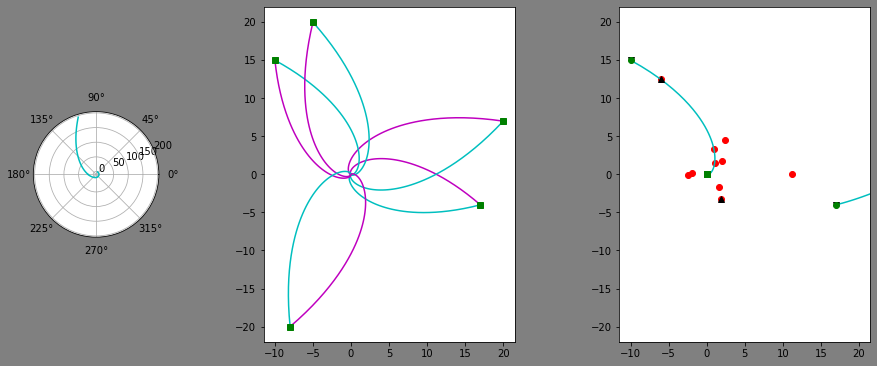

In [5]:
expl = FlowTreeBuilder()

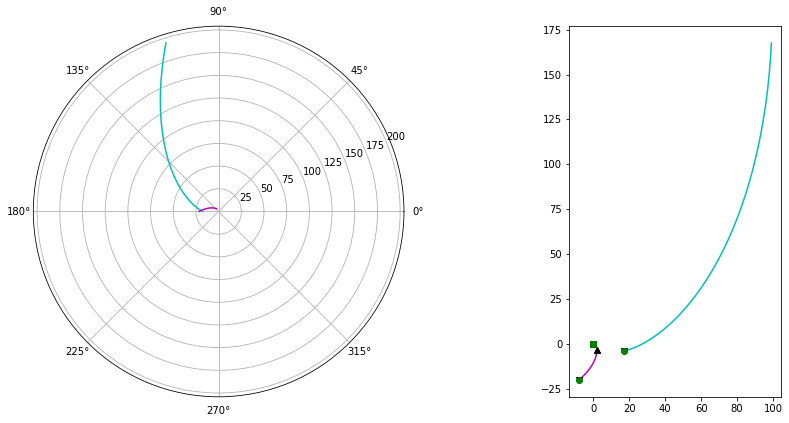

In [6]:
# тест работы LimitedSLC
fig = plt.figure(1,(15,15))
ax1 = fig.add_subplot(221,polar=True)
ax2 = fig.add_subplot(222,polar=False)

b=1.9
curve = LimitedSLC(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(20, 7), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(-10, 15), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-5, 20), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-8, -20), run=True)

intr = intersect(curve, curve1)['position_type']
curve.crop(intr[1],lowerlimit_xy=intr[0])
curve1.crop(rl_inverse(intr[1]),lowerlimit_xy=intr[0])

curve.batch_draw(ax1, ax2)
curve1.batch_draw(ax1, ax2)


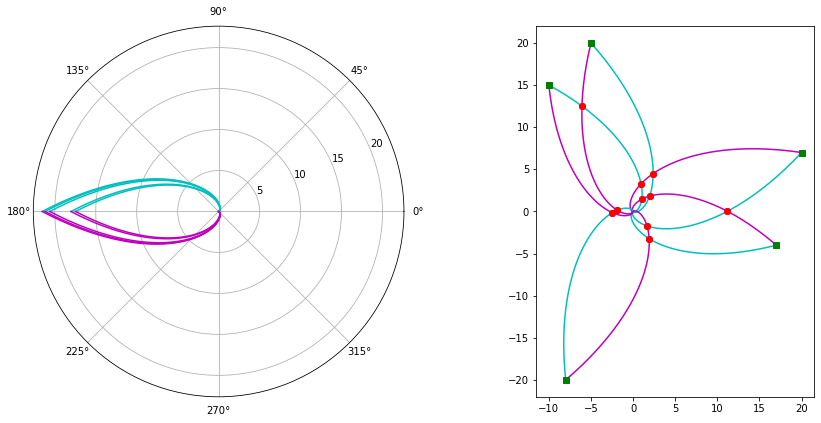

In [6]:
#тест работы intersect и draw на большом наборе
b = 1.9
curves = []
crd_tuple = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)
            # , (3,7)
            ]
for i in crd_tuple:
    curves.append(ShiftedLogCurve(b=b, root=(0,0), leaf=i, run=True))
draw(curves)
for i in curves:
    b = curves.copy()
    b.remove(i)
    for c in b:
        intersect(i, c, plotting=True)['position_type'][0]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

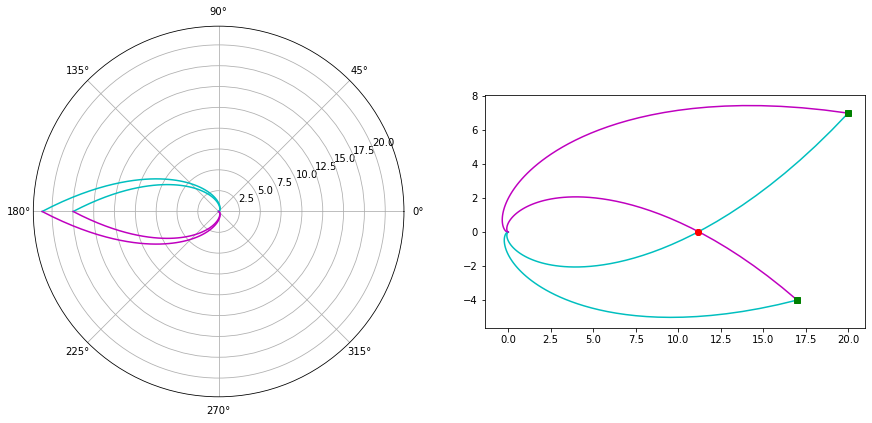

In [22]:
# тес работы intersect на двух кривых
b=1.9
curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(20, 7), run=True)

# Пример отсутствия пересечений:
# curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(-10, 15), run=True)
# curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(-5, 5), run=True)

#th_use = np.linspace(0, 10, 100)
#curve.eval_a()
#curve.draw()
draw([curve1, curve])
intersect(curve, curve1, True)
assert i1 == i2
curve.a

0.14500123881377888

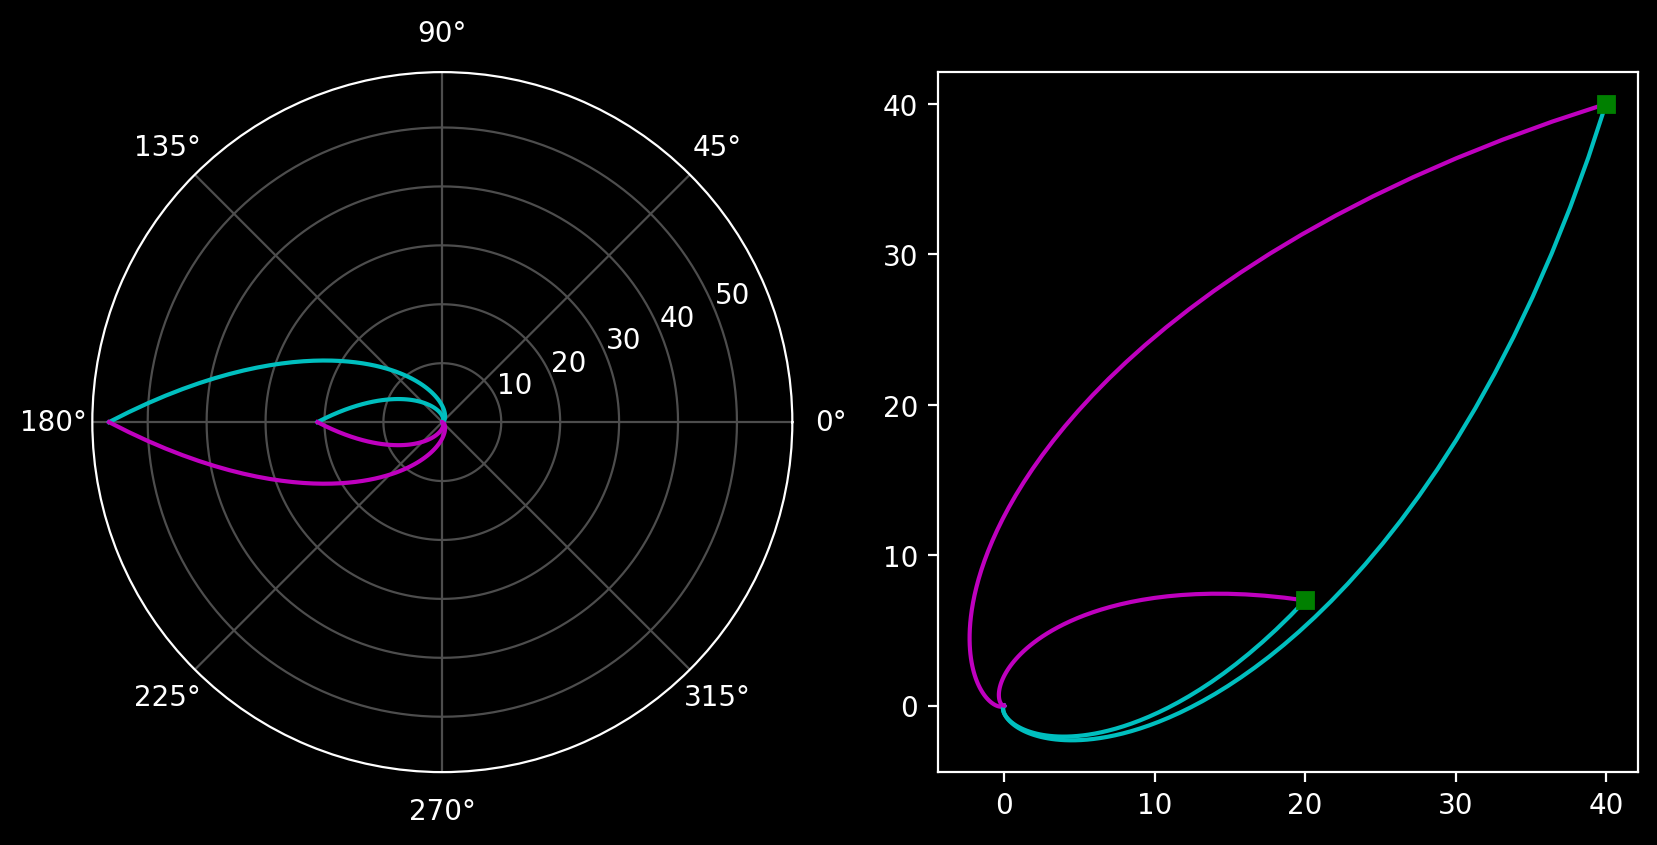

In [ ]:
# Пример плохого подбора параметра b. Не удалять!
b=1.9
curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(40, 40))
curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(20, 7))
th_use = np.linspace(0, 10, 100)
#curve.eval_a()
#curve.draw()
draw([curve, curve1])
curve.a

In [ ]:
curve.eval_r()

array([ 0.        ,  0.03640596,  0.07398573,  0.11277714,  0.15281928,
        0.19415246,  0.23681831,  0.2808598 ,  0.32632127,  0.37324853,
        0.42168881,  0.47169092,  0.5233052 ,  0.57658363,  0.63157988,
        0.68834932,  0.74694912,  0.80743831,  0.8698778 ,  0.93433047,
        1.00086124,  1.06953709,  1.1404272 ,  1.21360296,  1.28913807,
        1.36710858,  1.44759303,  1.53067247,  1.61643057,  1.70495369,
        1.79633098,  1.89065448,  1.98801916,  2.08852309,  2.19226747,
        2.2993568 ,  2.40989892,  2.52400515,  2.6417904 ,  2.76337331,
        2.8888763 ,  3.01842578,  3.15215221,  3.29019026,  3.43267896,
        3.57976179,  3.73158689,  3.88830715,  4.0500804 ,  4.21706957,
        4.38944283,  4.56737376,  4.75104157,  4.94063122,  5.13633364,
        5.33834592,  5.54687151,  5.76212041,  5.98430939,  6.21366222,
        6.45040987,  6.69479077,  6.94705102,  7.20744469,  7.476234  ,
        7.75368965,  8.04009106,  8.33572666,  8.64089418,  8.95